Total images: 200
First prints: 100
Second prints: 100


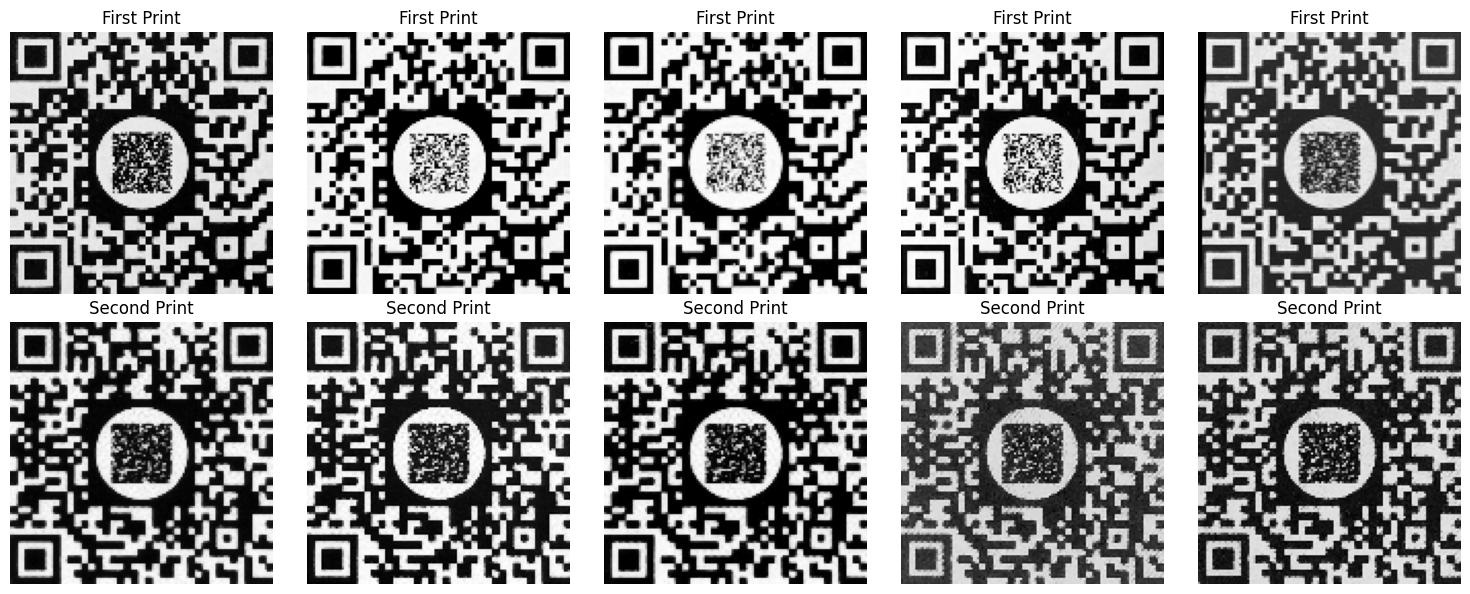

Random Forest Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Epoch 1/15


c:\Users\shukl\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.5049 - loss: 1.1580 - val_accuracy: 0.4750 - val_loss: 0.7025
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.5037 - loss: 0.6825 - val_accuracy: 0.8250 - val_loss: 0.6785
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.7911 - loss: 0.6693 - val_accuracy: 0.5250 - val_loss: 0.6415
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.5253 - loss: 0.6443 - val_accuracy: 0.8000 - val_loss: 0.5824
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.7662 - loss: 0.5976 - val_accuracy: 0.9500 - val_loss: 0.5072
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.8852 - loss: 0.5069 - val_accuracy: 0.9750 - val_loss: 0.3623
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.9010 - loss: 0.3504 - val_accuracy: 0.9500 - val_loss: 0.2342
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9308 - loss: 0.2438 - val_accuracy: 0.8250 - val_loss: 0.2349
Epo

In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def load_images_from_folders(first_print_folder, second_print_folder):
    images = []
    labels = []
    
    for folder, label in [(first_print_folder, 0), (second_print_folder, 1)]:
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (128, 128))  # Resize to 128x128
                images.append(img)
                labels.append(label)
                
    return np.array(images), np.array(labels)

# Specify dataset locations
data_folder_first = "First Print"
data_folder_second = "Second Print"

# Load dataset
X, y = load_images_from_folders(data_folder_first, data_folder_second)
X = X / 255.0  # Normalize images

# Display dataset statistics
print(f"Total images: {len(X)}")
print(f"First prints: {np.sum(y == 0)}")
print(f"Second prints: {np.sum(y == 1)}")

# Enhanced visualization of dataset
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axes[0, i].imshow(X[i], cmap='gray')
    axes[0, i].set_title("First Print")
    axes[0, i].axis("off")
    axes[1, i].imshow(X[-(i+1)], cmap='gray')
    axes[1, i].set_title("Second Print")
    axes[1, i].axis("off")
plt.tight_layout()
plt.show()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Feature Engineering (Edge detection and Histogram of Oriented Gradients)
def extract_features(images):
    feature_list = []
    for img in images:
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
        edges = np.sqrt(sobelx**2 + sobely**2).flatten()
        hist = cv2.calcHist([np.uint8(img * 255)], [0], None, [256], [0, 256]).flatten()
        feature_list.append(np.concatenate((edges, hist)))
    return np.array(feature_list)

X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

# Traditional ML Model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Deep Learning Model
X_train_dl = X_train.reshape(-1, 128, 128, 1)
X_test_dl = X_test.reshape(-1, 128, 128, 1)

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_dl, y_train, epochs=15, validation_data=(X_test_dl, y_test))

# Evaluate model
y_pred_cnn = (model.predict(X_test_dl) > 0.5).astype(int)
print("CNN Accuracy:", accuracy_score(y_test, y_pred_cnn))
print(classification_report(y_test, y_pred_cnn))

# Improved Misclassification analysis
misclassified = np.where(y_pred_cnn.flatten() != y_test)[0]
if len(misclassified) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, idx in enumerate(misclassified[:5]):
        axes[0, i].imshow(X_test[idx], cmap='gray')
        axes[0, i].set_title(f"Pred: {y_pred_cnn[idx][0]}, True: {y_test[idx]}")
        axes[0, i].axis("off")
    for i, idx in enumerate(misclassified[-5:]):
        axes[1, i].imshow(X_test[idx], cmap='gray')
        axes[1, i].set_title(f"Pred: {y_pred_cnn[idx][0]}, True: {y_test[idx]}")
        axes[1, i].axis("off")
    plt.tight_layout()
    plt.show()

# Deployment Considerations
print("Deployment Considerations:")
print("1. The model should handle different scanning conditions and lighting variations.")
print("2. Using Histogram of Oriented Gradients improves feature extraction for ML models.")
print("3. Deep learning model benefits from more training data and augmentation.")
print("4. Future work: Deploy the model via a Flask or FastAPI-based web service.")
